In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/external/5-Minute Crafts.csv')

In [4]:
df.head()

,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment
0,v=lCePSP4lb-k,Wow! Let's go live! Epic decorations and DIYS,1,558,10825,45,8,3,1,4,1,5.625000,0,0,0.131818
1,v=G7O9iWWOtTY,EXTREME ROOM TRANSFORMATION || Cool Design Ide...,1,1020,184374,63,10,2,3,0,2,6.300000,0,0,0.112500
2,v=cd0u5IFxBdo,LATE SUMMER HACKS TO SAVE YOUR DAY,2,629,478170,34,7,0,7,0,2,4.857143,0,0,-0.300000
3,v=lWSXHFPqBfo,EVERY SMART PARENT KNOWS THESE USEFUL HACKS #s...,2,41,197359,51,8,1,7,1,1,6.375000,0,0,0.257143
4,v=qqPFeyd84Lg,SMART HACKS TO SAVE YOUR WEDDING DAY🤵‍👰‍💍🕊️,3,784,162025,43,7,0,7,0,2,6.142857,0,0,0.214286


In [5]:
df.shape

(4904, 15)

In [6]:
df.isnull().values.any()

False

[Text(0.5, 0, 'Active days since'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Accumalated distribution of Active days since')]

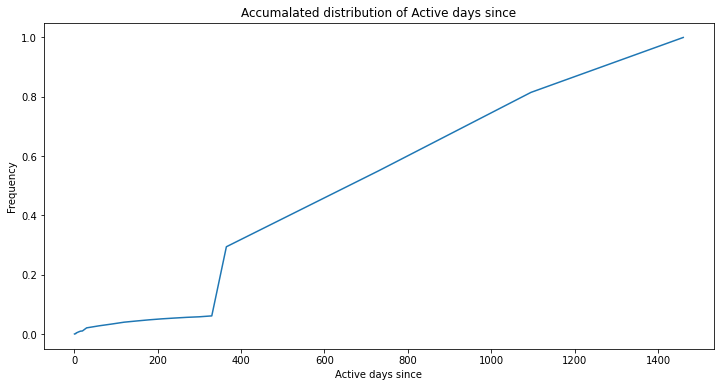

In [7]:
accumulated_percent = df.active_since_days.value_counts().sort_index() / df.active_since_days.count()
accumulated_percent = accumulated_percent.cumsum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(accumulated_percent.index, accumulated_percent)
ax.set(xlabel="Active days since",
       ylabel="Frequency",
       title="Accumalated distribution of Active days since")

In [8]:
accumulated_percent

1       0.000408
2       0.000816
3       0.001223
4       0.001427
5       0.004078
6       0.004282
10      0.006933
15      0.009788
20      0.010604
30      0.021003
60      0.027936
90      0.033850
120     0.040171
150     0.044250
180     0.048124
210     0.051387
240     0.054038
270     0.056485
300     0.058320
330     0.061378
365     0.294454
730     0.550571
1095    0.814845
1460    1.000000
Name: active_since_days, dtype: float64

In [9]:
df = df[df.active_since_days >= 365]
df.shape

(4603, 15)

In [10]:
df['view_rate'] = df['total_views'] / df['active_since_days']

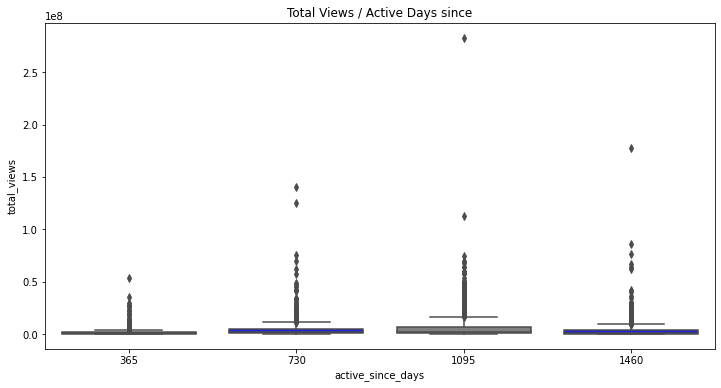

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Total Views",
       ylabel="Active Days Since",
       title="Total Views / Active Days since")

ax = sns.boxplot(x="active_since_days", y="total_views",
                 data=df, ax = ax, palette=['gray','blue'])